# PUBG: Battle Royal - Finish Placement Prediction

In [1]:
# Importing the required libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

##### The size of the PUBG dataset is pretty big for a lower/mid-range laptop so here's a script to make the dataset smaller without losing information.

###### It uses the following approach:

- Iterate over every column
- Determine if the column is numeric
- Determine if the column can be represented by an integer
- Find the min and the max value
- Determine and apply the smallest datatype that can fit the range of values
- This reduces the dataset from approx. 900 MB to 466 MB

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Loading train and test file and reducing its memeory consumption
#%%time
train = pd.read_csv('train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)


In [4]:
# Looking at first five train data
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


In [5]:
# Looking at last five train data
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


In [6]:
# Looking at first five test data
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0


In [7]:
# Looking at last five test data
test.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.000000,3,0,7,4,1294,4,2,69.269997,1292,squad-fpp,22,20,-1,1,0.0,0,0.000,0,0,1799.000000,5,1526
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.000000,0,0,0,64,1449,0,0,0.000000,1301,squad-fpp,27,26,-1,0,0.0,0,0.000,0,0,1195.000000,3,1496
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.959999,0,0,3,24,0,1,1,25.379999,1314,squad-fpp,29,29,1482,0,0.0,0,7.798,1,0,3327.000000,3,0
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.600006,0,0,12,25,0,1,1,67.889999,1333,duo-fpp,49,48,1456,1,0.0,0,0.000,0,0,1893.000000,4,0
1934173,3696fc9f3a42b2,c770d7feaf020f,9d4e2b6d506fd0,0,0,19.799999,0,0,0,86,1380,0,0,0.000000,1863,squad-fpp,28,27,-1,0,0.0,0,0.000,0,0,68.889999,0,1551


In [8]:
# To find the datatypes of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

## Tasks to be performed:
#### Part 1: Exploratory Data Analysis
#### Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters
#### Part 3: Feature Engineering
#### Part 4: Final Predition

### Part 1: Exploratory Data Analysis

In [9]:
# Unique count in column Id, groupId, matchId
for i in ['Id', 'groupId', 'matchId']:
    print("Unique values in column '{}' is: {}".format(i,train[i].nunique()) )

Unique values in column 'Id' is: 4446966
Unique values in column 'groupId' is: 2026745
Unique values in column 'matchId' is: 47965


###### Exploring diffrent match types:

In [10]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

- There classify the matchType into 3 types: Solo, Duo, Squad

In [11]:
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) else 'squad'

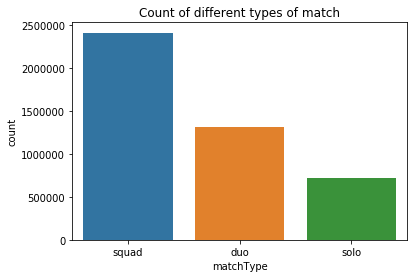

In [12]:
train['matchType'] = train['matchType'].apply(mapper)
sns.countplot(train['matchType'])
plt.title('Count of different types of match')
plt.show()

###### Checking correlation of features with Win Percentage:

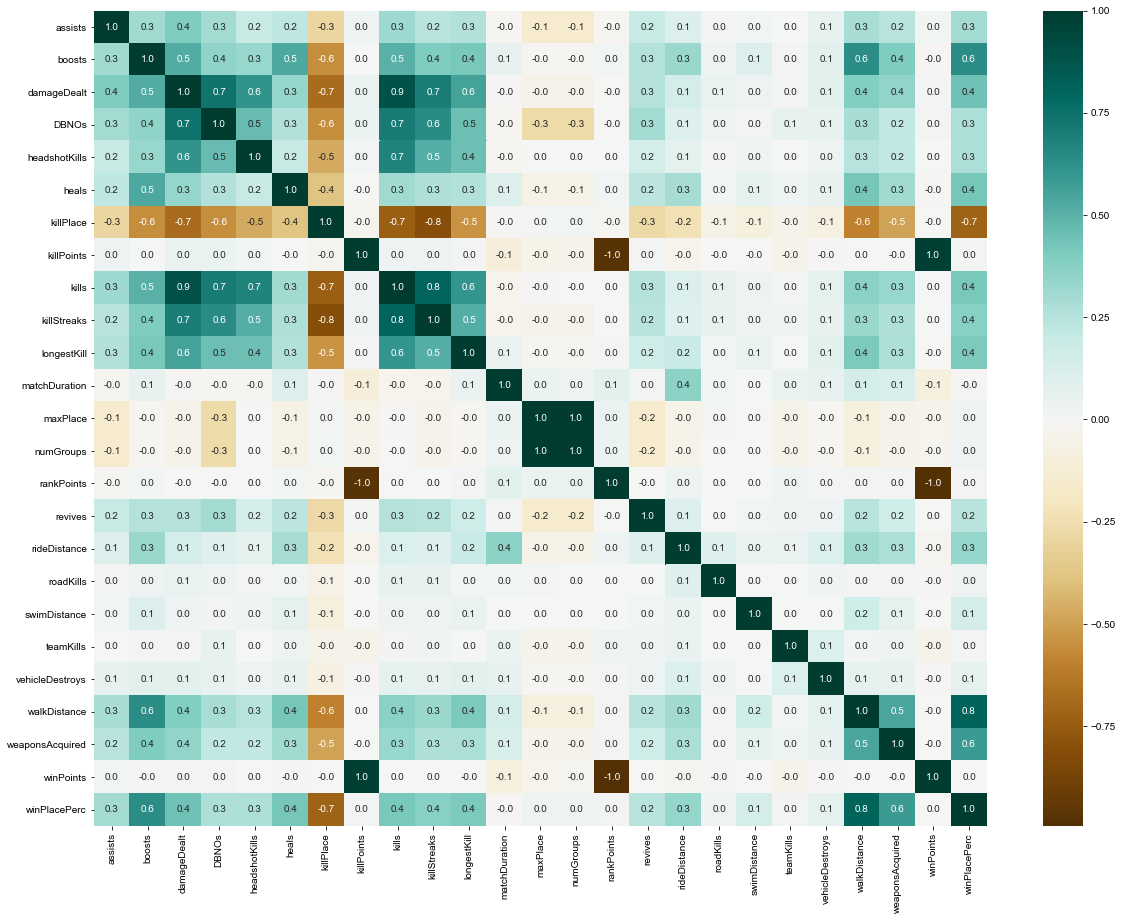

In [13]:
corr = train.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f', cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

###### Analysing the Kill

In [14]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

On an average a person kills 0.9248 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


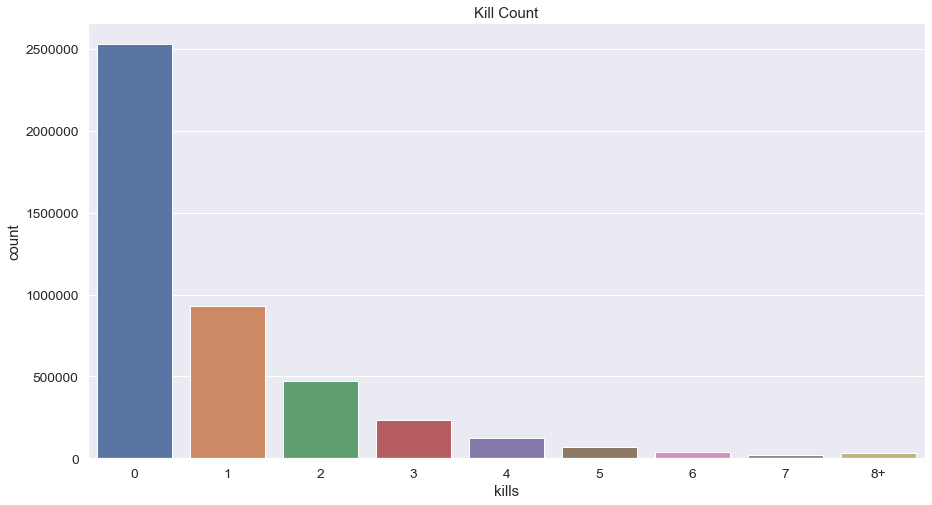

In [15]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype(str).sort_values())
plt.title("Kill Count")
plt.show()

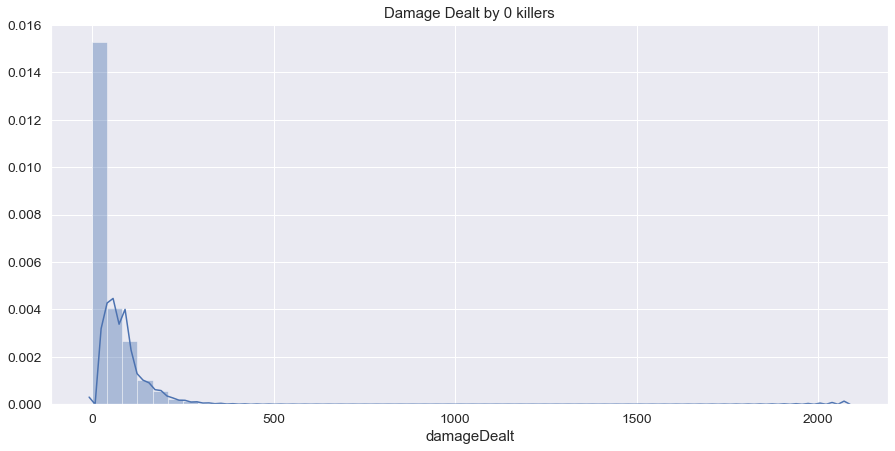

In [16]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,7))
plt.title("Damage Dealt by 0 killers")
sns.distplot(data['damageDealt'])
plt.show()

In [17]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won without a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


##### Effect of Kiiling on Winning percentage

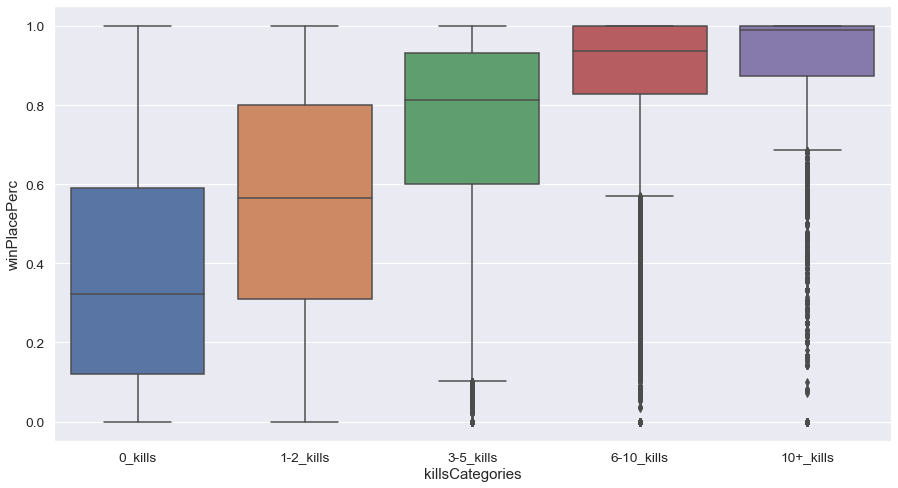

In [18]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=[
    '0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

- 'kills' has a high correlation with winPlacePerc.

###### Analysing Walk Distance

In [19]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players (2.0329%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


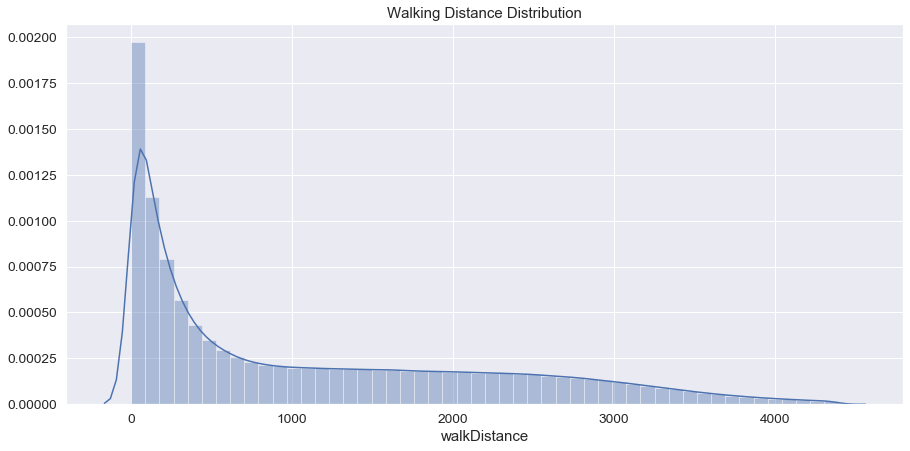

In [20]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,7))
plt.title("Walking Distance Distribution")
sns.distplot(data['walkDistance'])
plt.show()

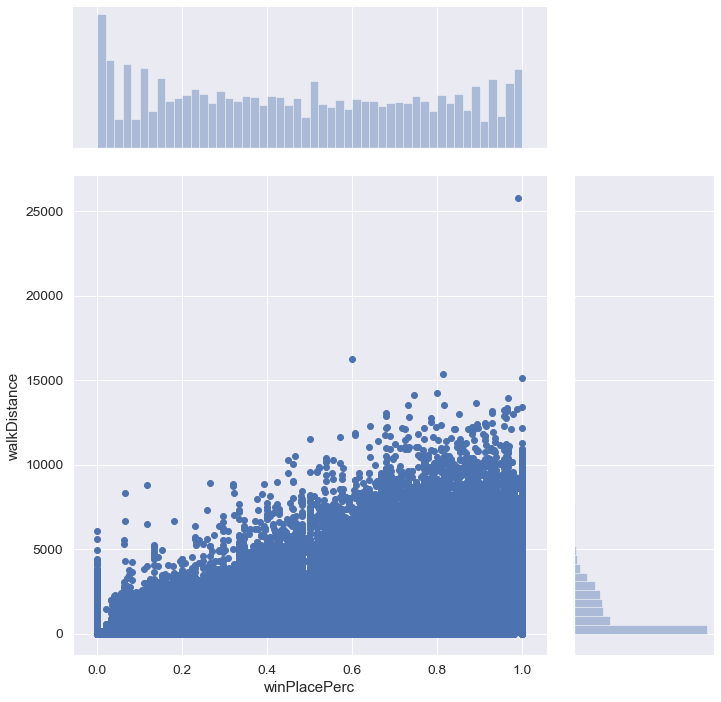

In [21]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3)
plt.show()

- Walking has a high correlation with winPlacePerc.

##### Analysing Riding

In [22]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE RIDER rode for 40710.0m.


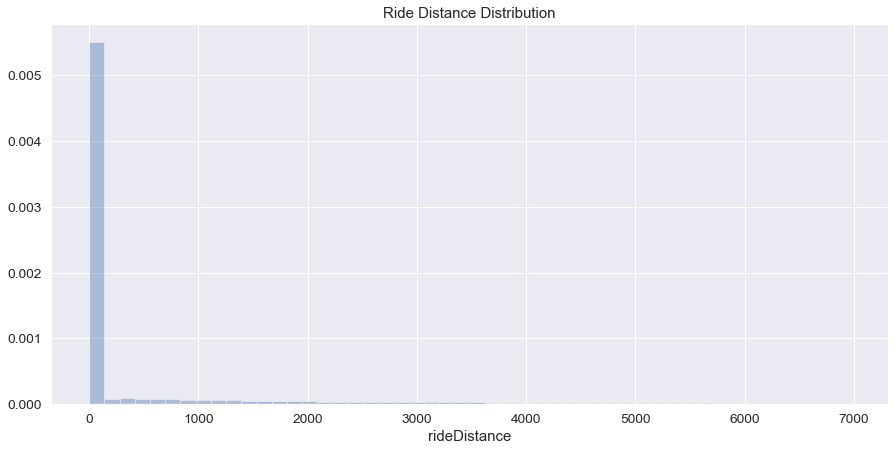

In [23]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,7))
plt.title("Ride Distance Distribution")
sns.distplot(data['rideDistance'])
plt.show()

In [24]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they like trekking more than riding.


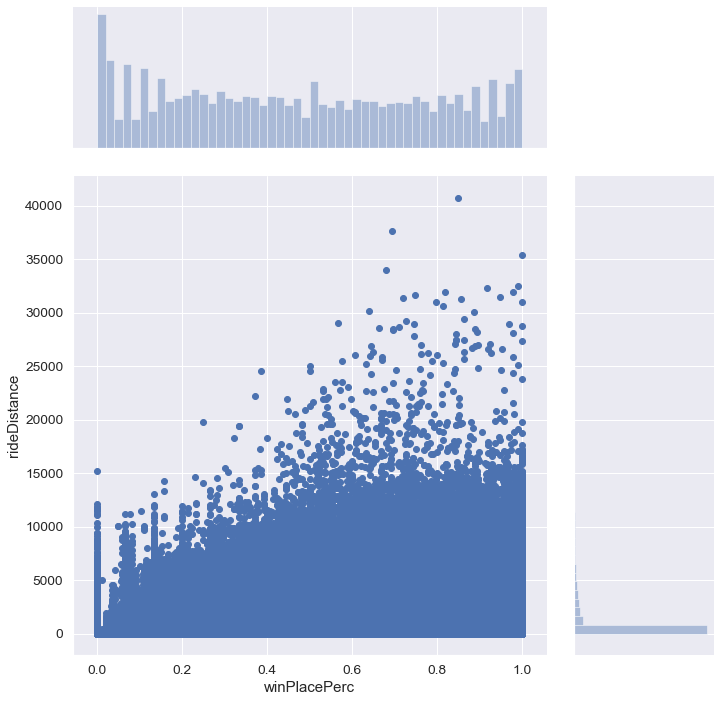

In [25]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3)
plt.show()

###### Theoretically, if a player is able to destroy the vehicle it indicates the he/she is skilled. Let's check if this theory is correct.

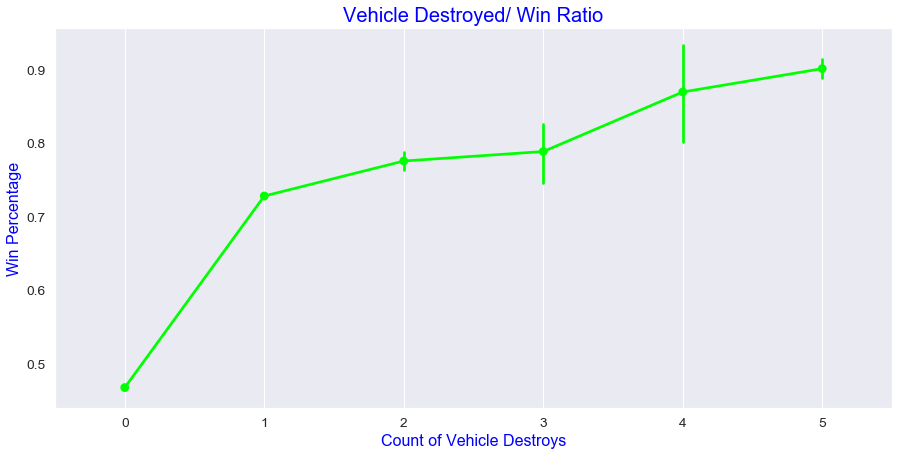

In [26]:
plt.figure(figsize =(15,7))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='lime',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

- Destroying vehicles increases your chances of winning!

### Analysing Healing and Boosting


In [27]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the maximun used is {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the maximun used is {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the maximun used is 80.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the maximun used is 33.


### Analysing Healing and Boosting: Effect of Healing & Boosting on Winning Percentage

In [28]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

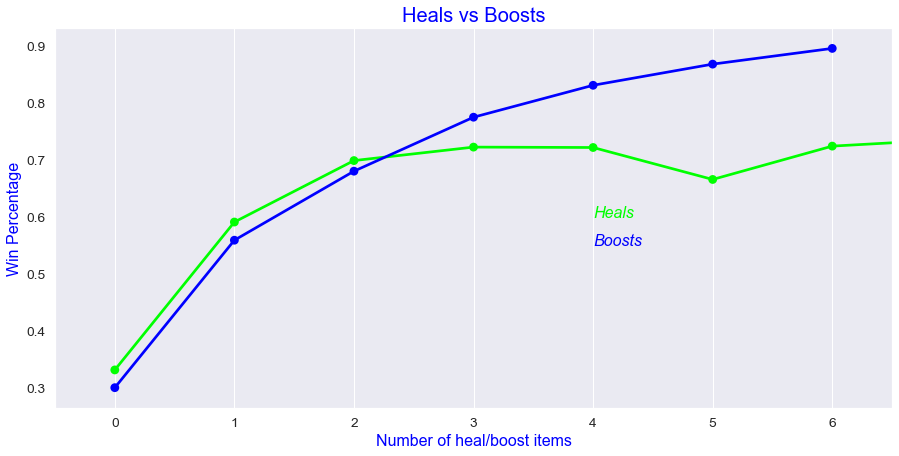

In [29]:
f,ax1 = plt.subplots(figsize =(15,7))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

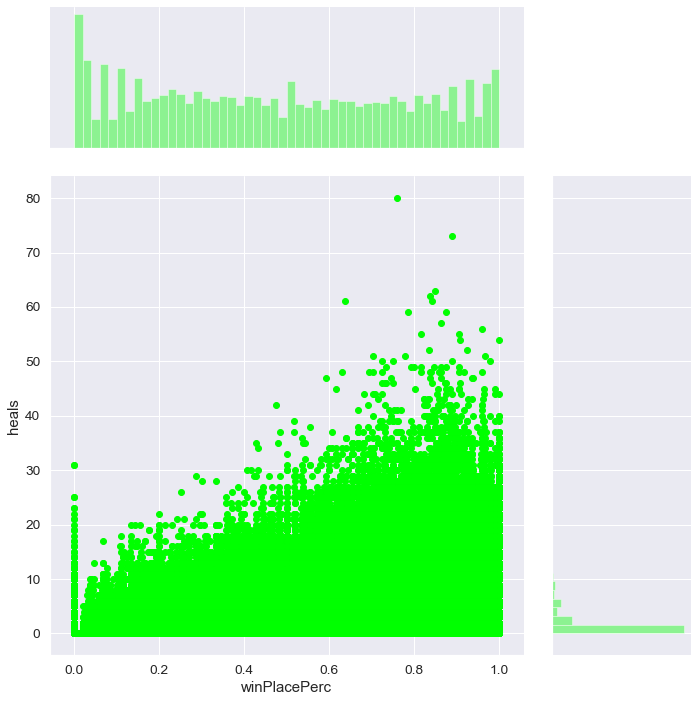

In [30]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

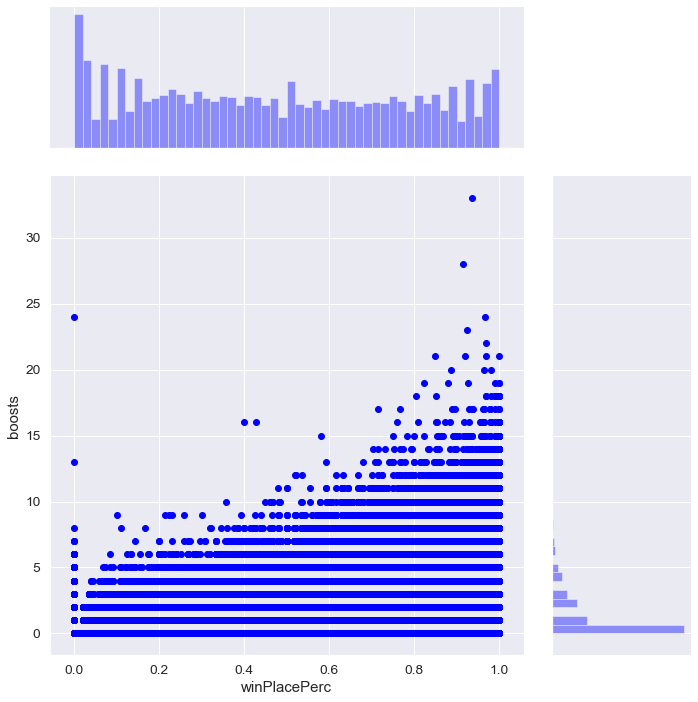

In [31]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

- Both healing and boosts have a high correlation with winning, however boosts matter more.

### Analyzing Effect of Knocking (DBNO), Assisting or Reviving on Winning Percentage

In [32]:
data = train[train['matchType'] != 'solo']

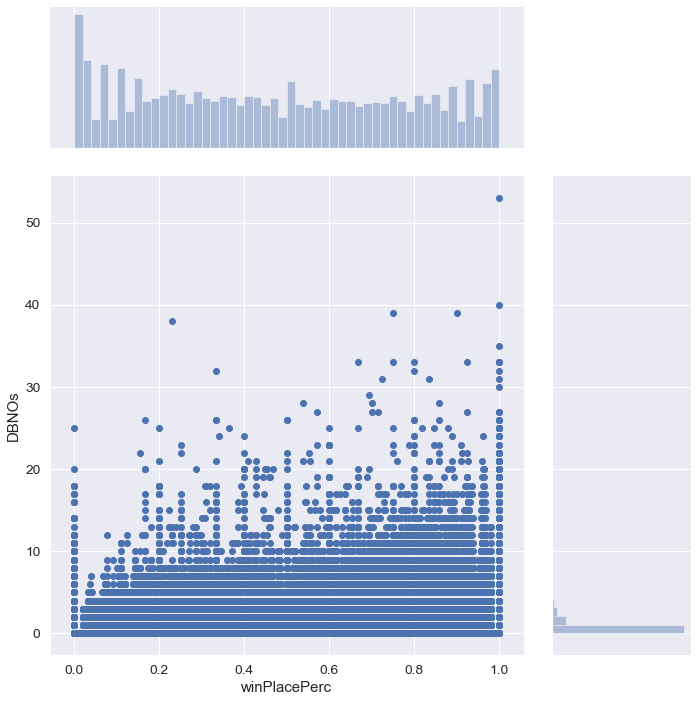

In [33]:
sns.jointplot(x="winPlacePerc", y="DBNOs", data=train, height=10, ratio=3)
plt.show()

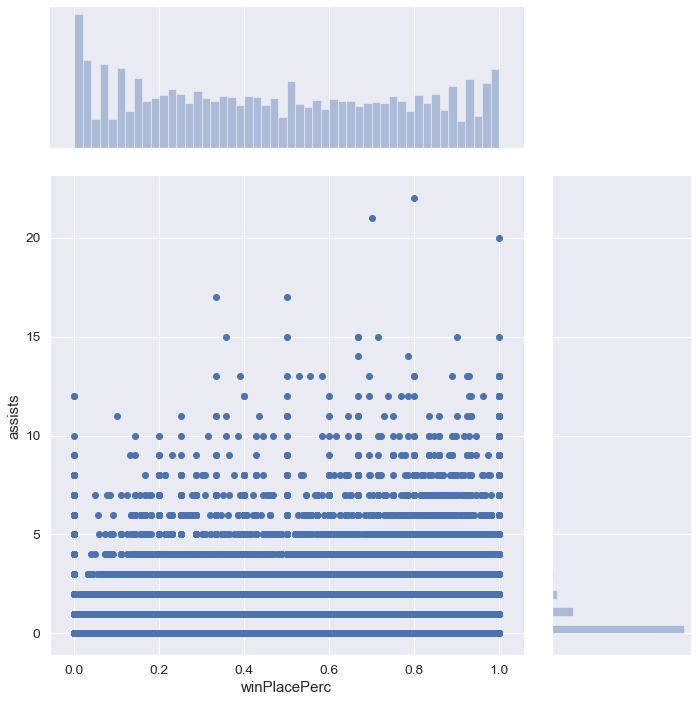

In [34]:
sns.jointplot(x="winPlacePerc", y="assists", data=train, height=10, ratio=3)
plt.show()

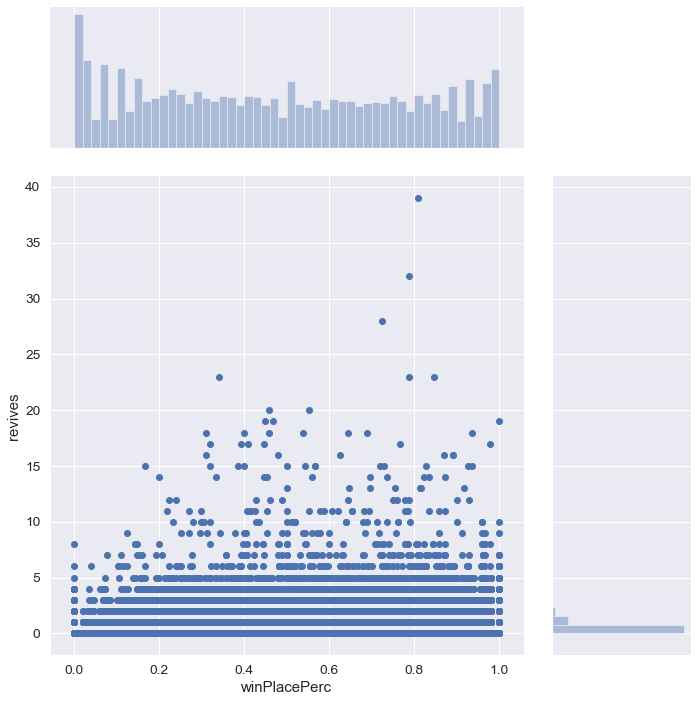

In [35]:
sns.jointplot(x="winPlacePerc", y="revives", data=train, height=10, ratio=3)
plt.show()

### Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters

In [36]:
# Checking row with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [37]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

In [38]:
# Engineer a new feature _totalDistance
train['_totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

Creating a new feature 'headshot_rate'. We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

In [39]:
# Engineer _headshot_rate feature --- headshots made per kill
train['_headshot_rate'] = train['headshotKills'] / train['kills']
train['_headshot_rate'] = train['_headshot_rate'].fillna(0)

#### Inhumane kills

In [40]:
#Defining some functions for plotting graphs
def show_countplot(column):
    plt.figure(figsize=(15,7))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15,7))
    sns.distplot(train[column],kde=True, bins=50)
    plt.show()

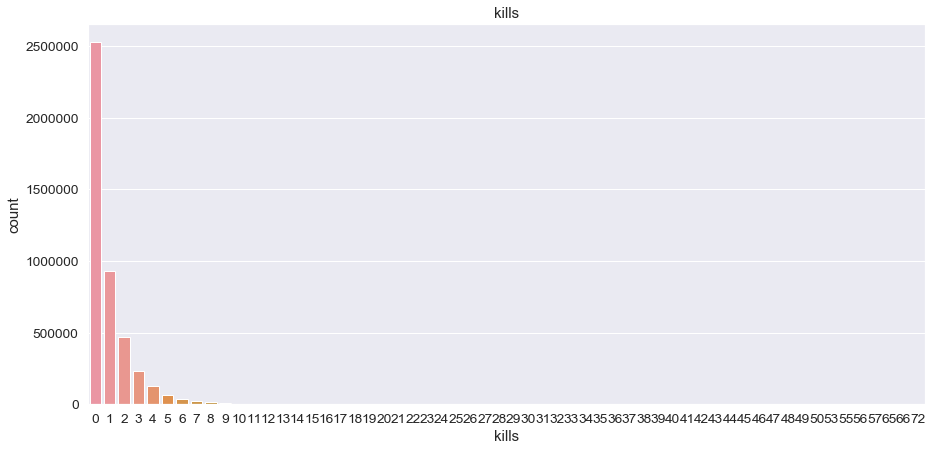

In [41]:
show_countplot('kills')

In [42]:
# Is it even possible to kill more than 40 people by acquiring more than 55 weapons and maintaining a total distance of less than 100m?
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,solo,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,0,57,5,104.199997,1798,duo,15,12,1500,0,0.0,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.790001,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.100006,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951


In [43]:
# Is it even possible to kill more than 40 people without using any heals?
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.200012,844,squad,8,8,-1,0,0.0,0,0.0,1,0,718.299988,16,1500,1.0,718.299988,0.952381
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,0,43,9,248.800003,911,squad,6,6,1500,1,0.0,0,0.0,0,0,80.400002,21,0,1.0,80.400002,0.790698
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.0,31,3,0,1,0,40,6,365.200012,1066,squad,10,9,1500,0,0.0,0,0.0,0,0,1282.000000,22,0,1.0,1282.000000,0.075000
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4347.0,0,31,0,1,0,53,8,135.600006,1116,solo,37,26,1500,0,0.0,0,0.0,0,0,134.300003,36,0,1.0,134.300003,0.584906
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,1000,40,20,621.799988,799,squad,10,10,-1,0,0.0,0,0.0,0,0,1180.000000,2,1500,1.0,1180.000000,0.875000


In [44]:
# Drop 'fraudsters' from above df
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0)].index, inplace=True)

#### 100% Headshot Kills

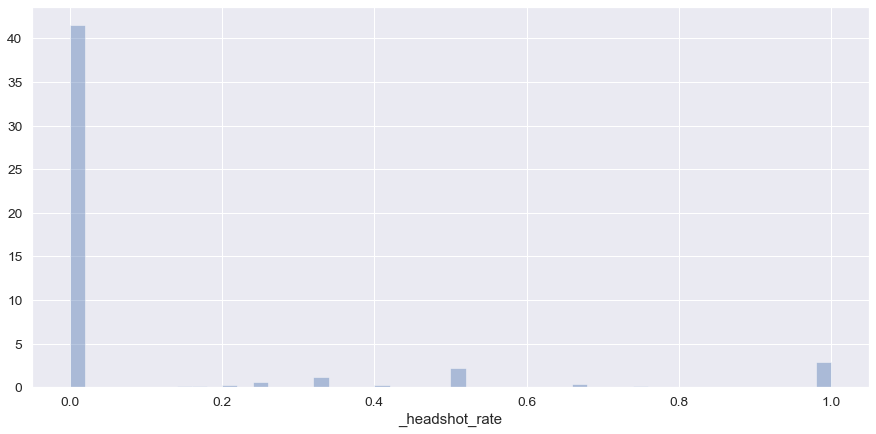

In [45]:
# Plot the distribution of headshot_rate
show_distplot('_headshot_rate')

In [46]:
# List of Hitman who made more than 10 kills and all the kills were done by headshot(perfect kill)
display(train[(train['_headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.199997,1423,squad,27,25,1564,1,0.000000,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.599976,1727,squad,27,26,-1,3,4720.000000,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.799988,1255,squad,27,27,-1,0,0.000000,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.200012,1838,squad,28,24,-1,0,5187.000000,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000000,1417,squad,27,26,-1,0,1018.000000,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.899994,1821,squad,28,27,1495,0,5246.000000,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000000,1246,squad,27,27,-1,0,408.899994,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000000,1730,squad,28,28,1560,0,2048.000000,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.600006,1248,duo,46,41,0,1,0.000000,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.139999,1379,duo,49,48,1813,0,0.000000,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0


- The headshotKills looks OK. So we will not delete these as of now.

#### Killing without Moving

In [47]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['_totalDistance'] == 0))
# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,squad,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,solo,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,squad,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,0,6,2,81.919998,583,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.300003,550,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,0,7,2,84.370003,599,squad,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,1000,2,1,26.990000,732,squad,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,0,1,1,16.440001,715,squad,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,0.0,0.000000,True


In [48]:
# Droping kill without moving 'fraudsters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

#### Longest Kill

Most kills are made from a distance of 100 meters or closer. However there are some players (outliers) who make a kill from more than 1km away. These players are probably fraudsters.

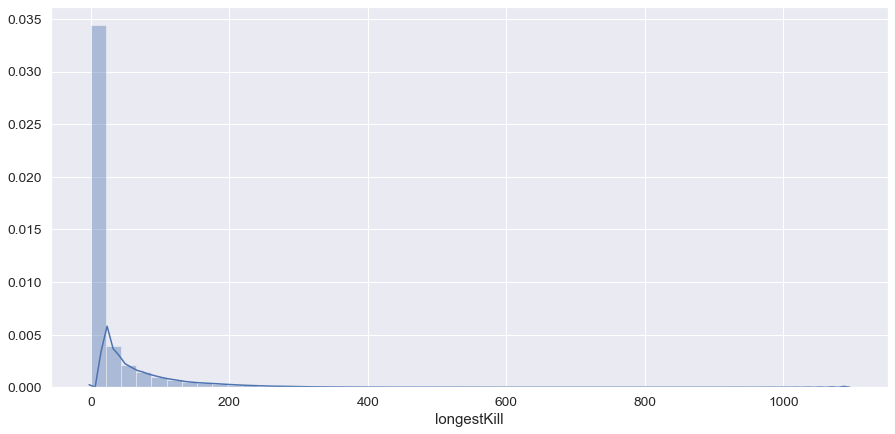

In [49]:
show_distplot('longestKill')

In [50]:
# players who took these shots from more than 1km
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.200012,0,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,1000,11,2,1004.0,1308,duo,14,13,-1,1,0.000000,0,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,0,10,2,1026.0,698,squad,13,13,1500,0,1717.000000,0,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,1000,16,4,1000.0,1091,squad,6,6,-1,4,0.000000,0,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,0,1,1,1075.0,471,squad,8,8,1500,0,2085.000000,0,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,0,10,3,1094.0,1021,squad,12,12,1500,0,0.000000,0,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,1000,3,1,1037.0,581,squad,8,7,-1,0,0.000000,0,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000000,0,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,0,23,2,1005.0,1798,duo,15,12,1500,0,0.000000,0,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,0,11,2,1037.0,1794,squad,11,11,1500,0,0.000000,0,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [51]:
# Droping these players
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

#### Road Kills

In [52]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


For player Id c3e444f7d1289f rode just 5 meters but has killed 14 players in the roadkill. It is highly unlikely. Hence droping it.

In [53]:
# Drop roadKill 'fraudsters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

### Finding anomaly in travelling

In [54]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe().T

,count,mean,std,min,25%,50%,75%,max
walkDistance,4445397.0,1148.915405,1180.579834,0.0,155.399994,686.299988,1977.0000,25780.0
rideDistance,4445397.0,606.300598,1496.634888,0.0,0.000000,0.000000,0.2609,40710.0
swimDistance,4445397.0,4.510810,30.242937,0.0,0.000000,0.000000,0.0000,3823.0


#### Detecting Anomalies in Walking

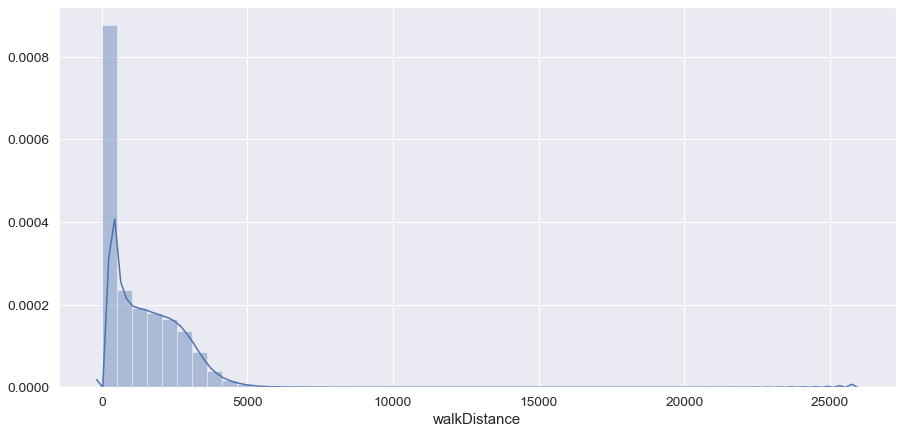

In [55]:
show_distplot('walkDistance')

In [56]:
# It is not possible for players to play to roam around and explore places without killing anyone 
# and how can they travel 13kms in the game?
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.0,1906,solo,99,93,1517,0,0.421200,0,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.0,1889,solo,95,93,1520,0,0.007800,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,0,0,0,0.0,1962,squad,29,27,1478,0,0.019800,0,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,0,0,0,0.0,1869,squad,29,29,1470,0,0.054800,0,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,0,0,0,0.0,1811,squad,29,27,1407,0,1258.000000,0,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.0,1977,squad,26,25,1482,0,0.040100,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,0,0,0,0.0,2012,squad,31,31,1474,0,847.700012,0,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.0,1828,solo,97,95,1651,0,0.011100,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,0,0,0,0.0,1805,squad,29,29,1542,0,1790.000000,0,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,0,0,0,0.0,1867,solo,93,89,1803,0,0.013900,0,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [57]:
# Drop walking anomalies
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

#### Detecting Anomalies in Riding

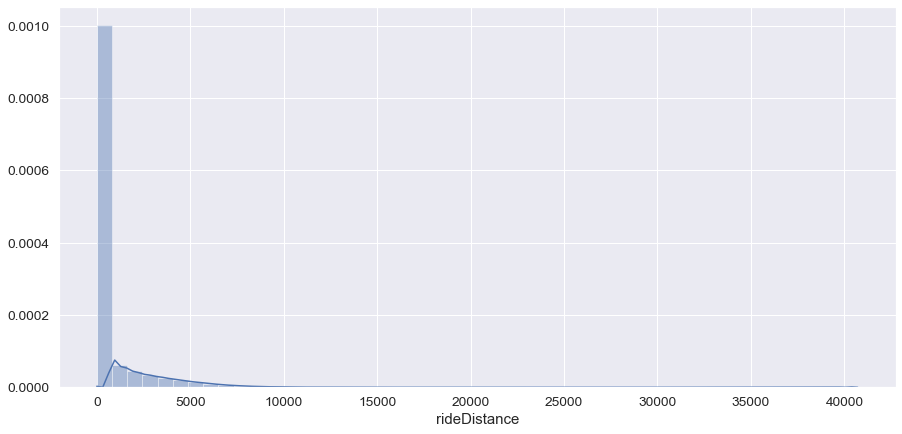

In [58]:
show_distplot('rideDistance')

In [59]:
# It is not possible for players to play to roam around and explore places without killing anyone 
# and how can you ride for 30km?
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.0,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.100006,3,1449,0.8171,32362.099609,0.0,False
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210000,0,0,0,27,1179,0,0,0.0,1851,solo,51,50,-1,0,33970.0,0,0.0,0,0,1641.000000,0,1498,0.6800,35611.000000,0.0,False
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.0,1896,solo,95,91,1501,0,31010.0,0,0.0,1,0,1473.000000,3,0,0.7979,32483.000000,0.0,False
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.389000,0,0,5,19,1193,0,0,0.0,1918,solo,37,35,-1,0,37670.0,0,0.0,0,0,542.099976,2,1565,0.6944,38212.101562,0.0,False
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000000,0,0,0,52,0,0,0,0.0,1794,solo,94,92,1512,0,31370.0,0,0.0,0,0,28.760000,0,0,0.7204,31398.759766,0.0,False
2700691,3428324a089608,fa77b4ac736dbf,9b1c87f4016f47,0,1,31.270000,0,0,0,46,1211,0,0,0.0,1886,solo,98,95,-1,0,31290.0,0,0.0,0,0,174.100006,1,1530,0.8557,31464.099609,0.0,False
2927408,260efc0cf6b36c,b112f8d21e8185,3e977510ce1d3c,0,0,11.220000,0,0,0,44,1281,0,0,0.0,1865,solo,92,90,-1,0,30660.0,0,0.0,0,0,426.600006,2,1619,0.8132,31086.599609,0.0,False
3404578,8e84f4228e5436,c5ca5892142cbd,56775920f704e8,0,0,3.298000,0,0,0,40,1060,0,0,0.0,1877,solo,98,96,-1,0,32320.0,0,0.0,0,0,233.699997,5,1497,0.9175,32553.699219,0.0,False
3567265,99f342c6022411,9158efebffecc7,ddbe41fe165c7f,2,2,113.199997,0,0,3,34,0,0,0,0.0,1958,duo,48,47,1729,1,31020.0,0,0.0,0,0,616.200012,4,0,1.0000,31636.199219,0.0,False
4099938,afe34618b04d77,c14f532b283844,732c3b752e055f,0,0,0.000000,0,0,0,42,0,0,0,0.0,1939,solo,93,90,1486,0,40710.0,0,0.0,0,0,560.099976,0,0,0.8478,41270.101562,0.0,False


In [60]:
# How is it even possible that a player is able to ride and kill without walking even a single meter ?
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
219621,49e86bcbb74918,5bf4ac7f5f89a0,05a97d10e3cf81,0,0,100.000000,1,0,0,38,0,1,1,2.150000,1979,squad,26,26,1465,0,673.099976,1,0.0,0,0,0.0,0,0,0.0000,673.099976,0.0,False
1051447,c43116d1c3d4e5,bd09c97b67800a,aad60eee7eeb79,0,0,102.199997,0,0,0,34,1320,1,1,4.489000,1935,solo,89,85,-1,0,1757.000000,1,0.0,0,0,0.0,0,1532,0.1250,1757.000000,0.0,False
1053213,4a8011f19b0e0e,037c89b0cef255,238171821a1d0e,1,0,100.000000,1,0,0,38,1621,1,1,1.440000,1881,duo,48,45,-1,0,36.240002,0,0.0,0,0,0.0,0,1747,0.0638,36.240002,0.0,False
1166930,553f199b5538c5,560c2ba9dcbbd0,afb05e37d884fc,2,0,168.500000,1,0,0,45,1398,1,1,3.268000,1799,squad,31,29,-1,0,391.799988,1,0.0,0,0,0.0,0,1499,0.0667,391.799988,0.0,False
1479750,bcdf0f6c5d08bf,ea2ed2cc5955dd,2b59ed013eaf15,0,0,100.000000,1,0,0,46,0,1,1,3.744000,1882,duo,50,47,1509,0,468.299988,1,0.0,0,0,0.0,0,0,0.0612,468.299988,0.0,False
2221273,a280df87d394fc,61042f8c96538c,a0e8fe0599288c,0,0,100.000000,1,0,0,37,0,1,1,4.656000,1982,duo,47,44,1506,0,534.500000,1,0.0,0,0,0.0,0,0,0.1522,534.500000,0.0,False
2382410,adbda59d2f11cd,343d453ffb18c8,cbb5f864c6f532,0,0,100.000000,1,0,0,43,0,1,1,1.564000,1807,squad,26,22,1530,0,262.700012,1,0.0,0,0,0.0,0,0,0.0000,262.700012,0.0,False
2471705,b968373063f5a8,536e9c19659ce8,61c90034dc8174,0,0,93.470001,1,0,0,38,0,1,1,3.395000,1758,squad,29,26,1500,0,1360.000000,1,0.0,0,0,0.0,0,0,0.1429,1360.000000,0.0,False
2907639,2bf1d34142358b,71c15011651348,08dfa30b9390f7,4,0,578.000000,0,0,6,30,0,3,1,17.719999,1007,squad,6,6,1500,0,1277.000000,0,0.0,0,0,0.0,29,0,0.4000,1277.000000,0.0,False
3778837,ca3ca72549b07f,68a0c84f3b09aa,f72f06cafb3349,0,0,144.300003,2,0,0,20,1183,2,1,5.206000,1785,squad,28,26,-1,0,415.399994,0,0.0,0,0,0.0,0,1496,0.0000,415.399994,0.0,False


In [61]:
# What was the player doing in the game when total distance travelled by him/her is 0? 
train[(train['_totalDistance'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.0000,0.0,0.0,False
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.0000,0.0,0.0,False
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0,False
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.1277,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446843,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,0,0,0,0.0,1902,squad,30,30,1456,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
4446849,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,1243,0,0,0.0,1472,solo,98,93,-1,0,0.0,0,0.0,0,0,0.0,0,1363,0.0412,0.0,0.0,False
4446905,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,0,0,0,0.0,1371,duo,49,48,1465,0,0.0,0,0.0,0,0,0.0,1,0,0.0417,0.0,0.0,False
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,526,0,0,0.0,1811,squad,29,29,-1,0,0.0,0,0.0,0,0,0.0,0,916,0.0000,0.0,0.0,False


In [62]:
# Drop riding anomalies
train.drop(train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['_totalDistance'] == 0)].index, inplace=True)

#### Swim Distance

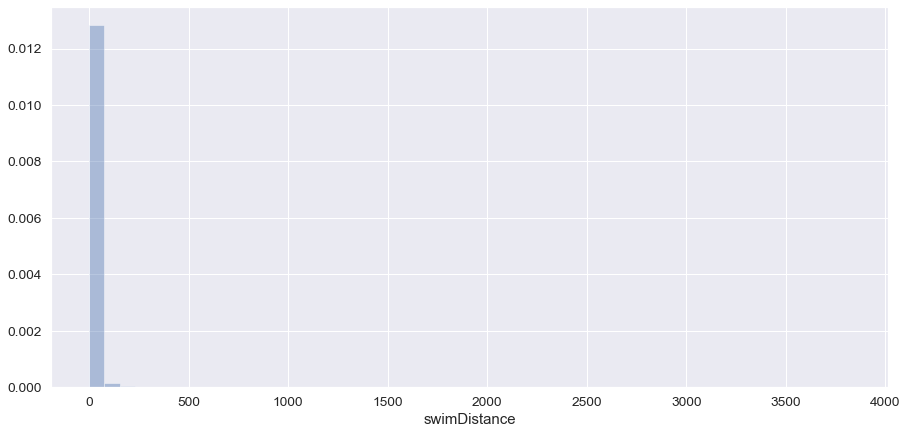

In [63]:
show_distplot('swimDistance')

In [64]:
# How can player swim for more than 2 km without breathing?
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,1058,0,0,0.000000,1399,duo,50,46,-1,0,0.0,0,2295.0,0,0,1002.000000,4,1466,0.9592,3297.000000,0.000000,False
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5689.0,0,2148.0,0,0,2276.000000,5,0,0.9600,10113.000000,0.000000,False
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,1103,3,1,868.700012,1897,squad,26,25,-1,0,3331.0,0,2718.0,0,0,4691.000000,5,1516,1.0000,10740.000000,1.000000,False
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,1039,5,1,64.480003,1396,duo,49,48,-1,0,0.0,0,2668.0,0,0,415.100006,10,1499,1.0000,3083.100098,0.200000,False
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,0,2,1,48.209999,1021,squad,12,12,1500,0,0.0,0,3823.0,0,0,995.299988,9,0,1.0000,4818.299805,0.500000,False
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.000000,0,0,0,47,0,0,0,0.000000,1387,squad,25,23,1327,0,864.0,0,2484.0,0,0,1966.000000,3,0,0.5833,5314.000000,0.000000,False
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.590000,0,0,5,48,1097,0,0,0.000000,1379,duo,48,46,0,1,2089.0,0,3514.0,0,0,4296.000000,8,1492,0.8511,9899.000000,0.000000,False
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.399994,2,0,0,7,0,3,2,30.020000,1210,squad,27,24,1516,0,0.0,0,2387.0,0,0,7.546000,6,0,1.0000,2394.545898,0.000000,False
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.799988,5,5,2,2,0,7,1,696.799988,2188,squad,26,25,1628,1,3033.0,0,2206.0,0,0,4687.000000,4,0,0.9600,9926.000000,0.714286,False
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.000000,0,0,0,77,1056,0,0,0.000000,1372,squad,29,29,-1,0,0.0,0,2338.0,0,0,1750.000000,0,1518,0.2143,4088.000000,0.000000,False


In [65]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

#### Anomalies detection in Supplies (WeaponAcquired)


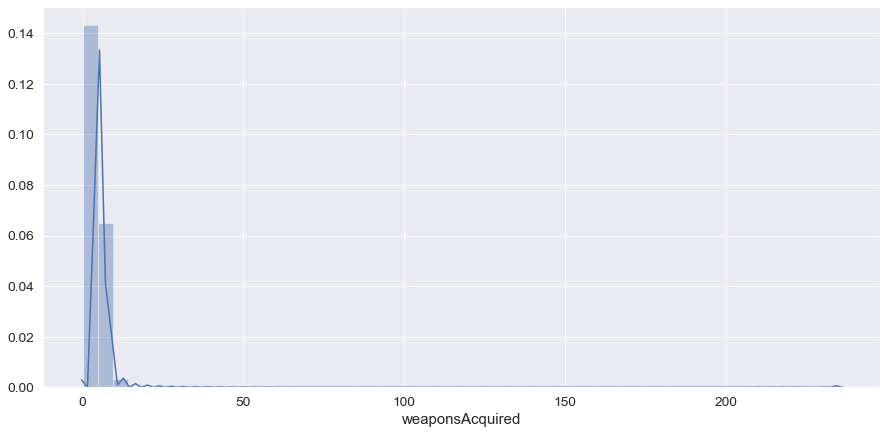

In [66]:
show_distplot('weaponsAcquired')

In [67]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(21, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.000000,0,0.000000,0,0,1307.000000,128,1577,0.7111,3187.000000,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,0,0,0,0.000000,1372,squad,29,29,1473,0,0.000000,0,0.000000,0,0,1687.000000,80,0,0.7500,1687.000000,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.599998,1840,squad,29,28,1528,0,2852.000000,0,47.209999,0,0,2400.000000,102,0,0.8929,5299.209961,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,0,0,0,0.000000,1330,squad,26,23,1442,0,0.000000,0,0.000000,0,0,653.099976,95,0,0.5600,653.099976,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5377.000000,0,8,4,3,0,53,3,53.610001,1798,solo,11,11,1500,0,954.400024,0,0.000000,0,0,1128.000000,83,0,0.8000,2082.399902,0.150943,False


In [68]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

#### Anomalies in Heals

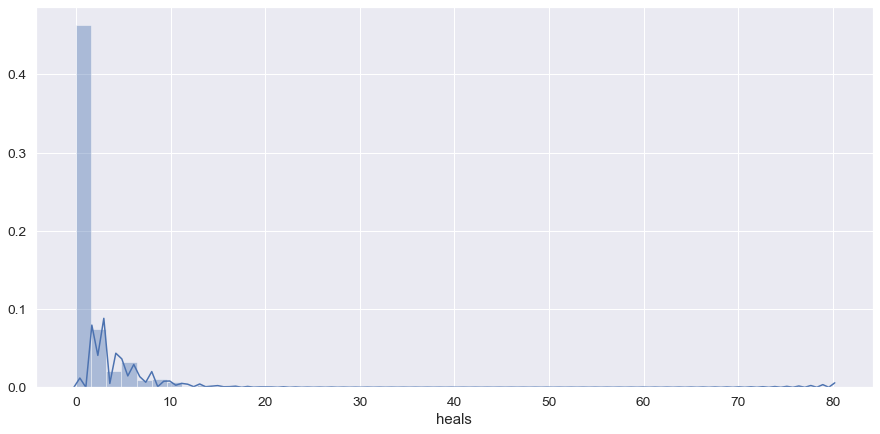

In [69]:
show_distplot('heals')

In [70]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000000,1797,solo,96,92,1527,0,5467.000000,0,0.000000,0,0,1387.000000,6,0,0.9368,6854.000000,0.000000,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515000,1532,squad,27,27,1500,0,0.000000,0,292.399994,0,0,2791.000000,7,0,0.9615,3083.399902,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000000,1374,solo,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993,0.000000,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000000,1769,solo,97,94,1563,0,5934.000000,0,0.000000,0,0,1510.000000,6,0,0.8646,7444.000000,0.000000,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000000,1878,solo,93,93,1500,0,3848.000000,0,0.000000,0,0,1968.000000,9,0,0.8370,5816.000000,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000000,1295,squad,28,28,-1,0,0.000000,0,0.000000,0,0,2439.000000,2,1511,0.9259,2439.000000,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000000,1965,squad,30,29,1506,0,2596.000000,0,0.000000,0,0,2252.000000,8,0,0.8276,4848.000000,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310001,1358,squad,32,31,-1,0,487.600006,0,0.000000,0,0,2928.000000,3,1562,0.9355,3415.600098,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190002,1797,solo,37,22,-1,0,0.000000,0,0.000000,0,0,268.799988,33,1500,0.8889,268.799988,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.419998,1807,squad,28,25,-1,1,2438.000000,0,0.000000,0,0,2489.000000,6,1517,0.9630,4927.000000,0.250000,False


In [71]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

In [72]:
train.shape

(4349359, 32)

In [73]:
train.to_csv('cleaned_data.csv', index=False)

In [74]:
cleaned_data = pd.read_csv('cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1032.82 MB --> 377.46 MB (Decreased by 63.5%)


### Part 3: Feature Engineering

A game in PUBG can have up to 100 players fighting each other. But most of the times a game isn't "full". There is no variable that gives us the number of players joined. So lets create one.

In [75]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0


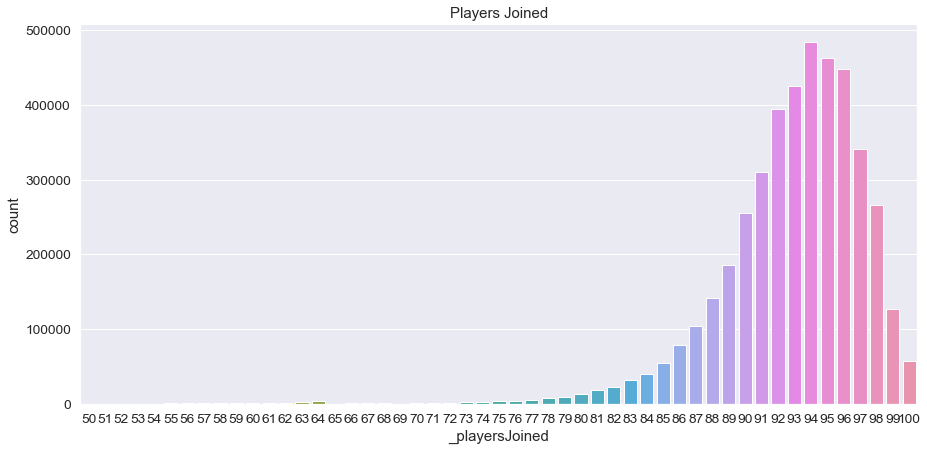

In [76]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,7))
sns.countplot(data['_playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

- There are a few matches with less than 75 players that cannot be displayed here. As you can see most of the matches are nearly packed and have almost 100 players.

#### Normalizing the features
Now that we have a feature '_playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:

- kills
- damageDealt
- maxPlace
- matchDuration

In [77]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]

,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.68,1306,1384.36
1,eef90569b9d03c,0,0.00,91.470001,100.617001,26,28.60,1777,1954.70
2,1eaf90ac73de72,0,0.00,68.000000,72.760000,50,53.50,1318,1410.26
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.06,100.000000,106.000000,97,102.82,1424,1509.44
5,ff79c12f326506,1,1.09,100.000000,109.000000,28,30.52,1395,1520.55
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,9.221040,96,103.68,1967,2124.36
8,1a68204ccf9891,0,0.00,51.599998,54.179998,28,29.40,1375,1443.75
9,e5bb5a43587253,0,0.00,37.270000,40.251600,29,31.32,1930,2084.40


In [78]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194


In [79]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

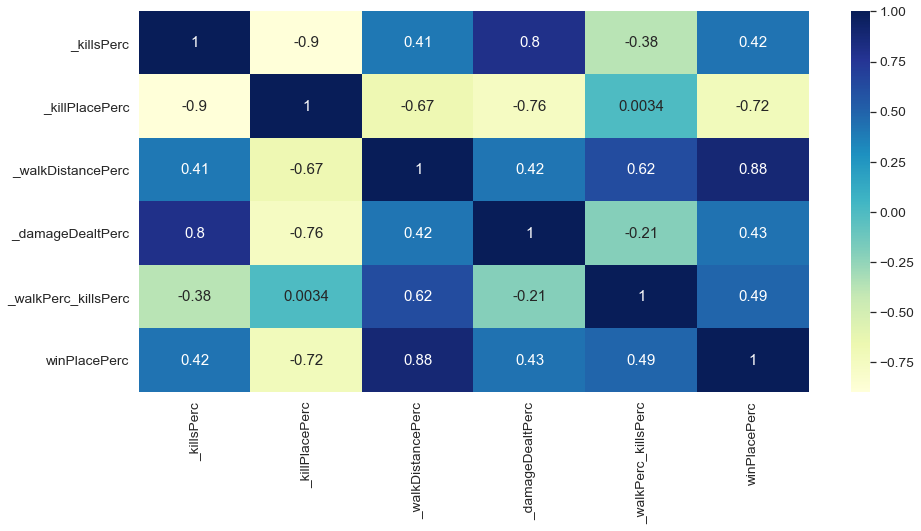

In [80]:
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot=True,cmap="YlGnBu")
plt.show()

In [81]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['_totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,NaN,2.142857,0.000000,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,NaN,2.192308,0.000000,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,NaN,0.940000,0.000000,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.0,0.463918,0.020101,0.020101,0.034937


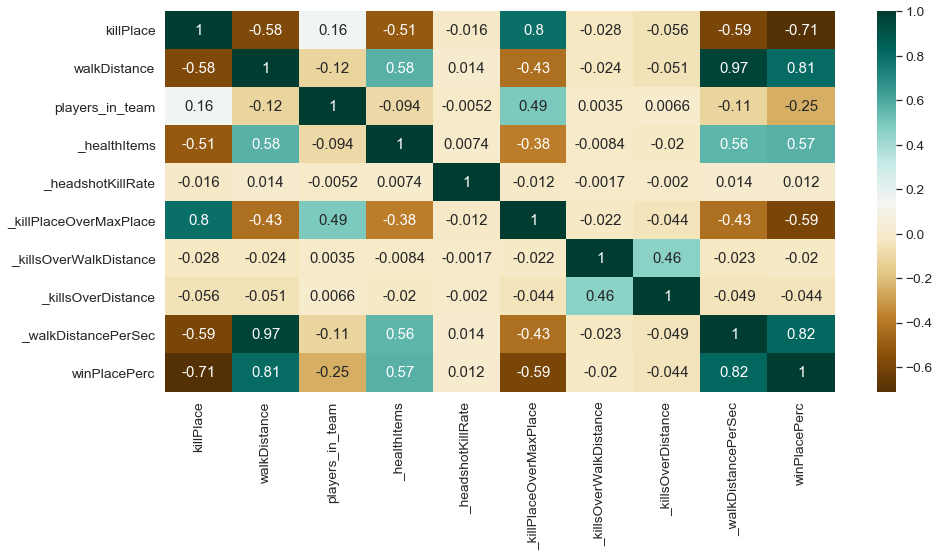

In [82]:
corr = cleaned_data[['killPlace', 'walkDistance','players_in_team','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot=True, cmap="BrBG")
plt.show()

In [83]:
# Less correlated wrt winPlacePerc
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [84]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


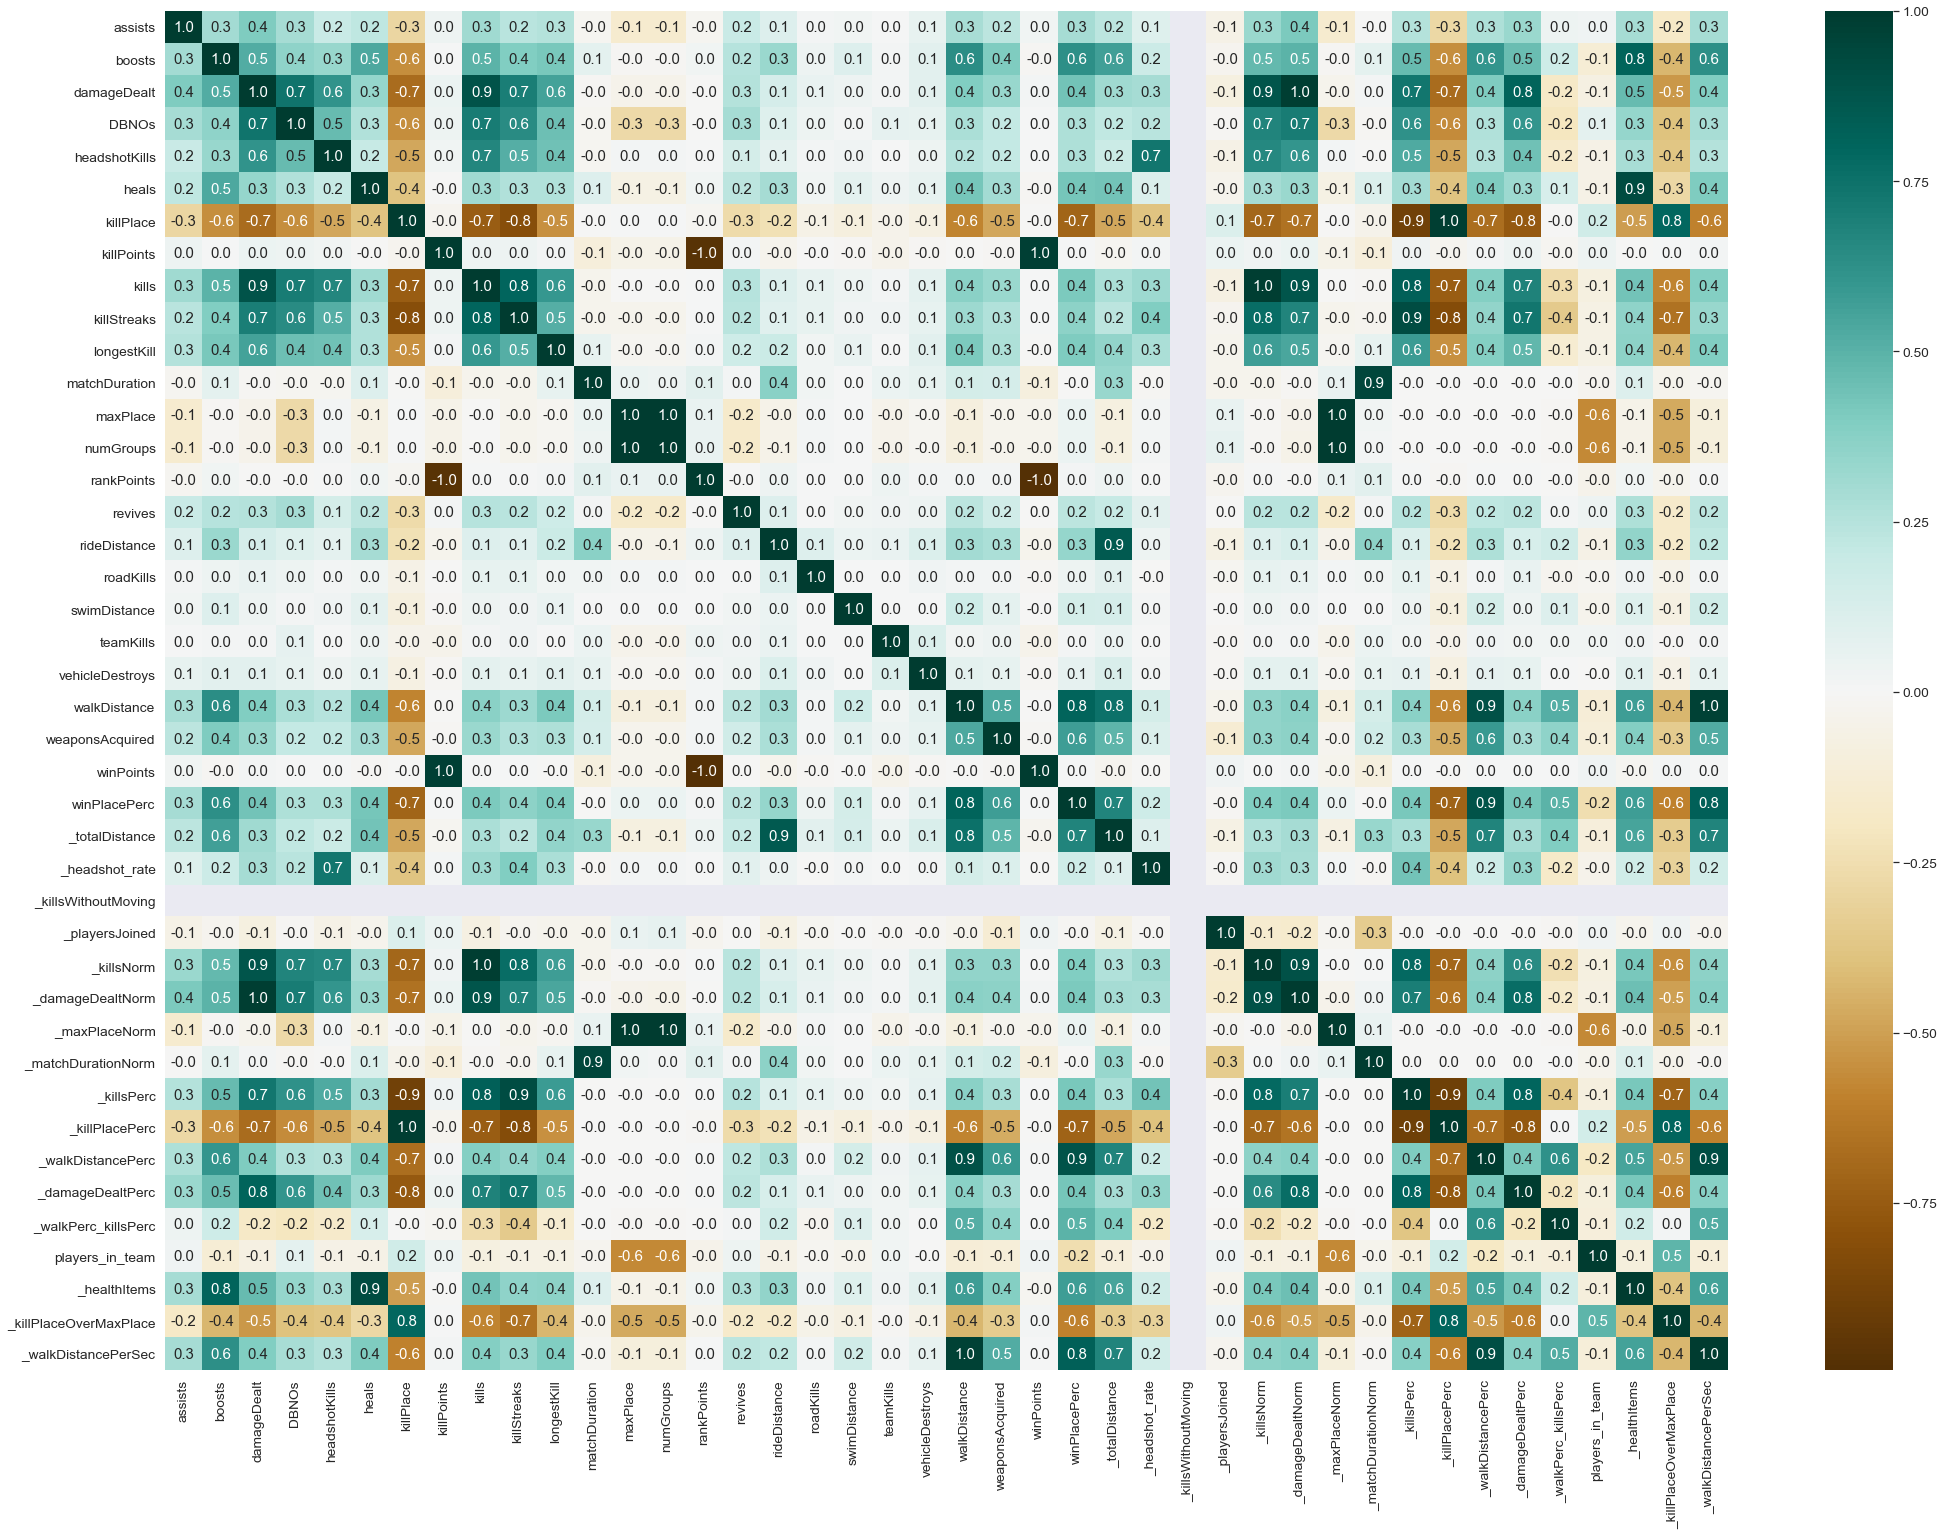

In [85]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(35, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

#### Removing features having 0 correlation with winPlacePerc

In [86]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints',
                   '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm', '_killsWithoutMoving'], axis=1, inplace=True)

In [87]:
len(cleaned_data.columns)

34

#### Removing features having high correlation 

In [88]:
corr_matrix = cleaned_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [89]:
to_drop

['kills',
 '_totalDistance',
 '_killsNorm',
 '_damageDealtNorm',
 '_killsPerc',
 '_killPlacePerc',
 '_walkDistancePerc',
 '_healthItems',
 '_walkDistancePerSec']

In [90]:
# Drop features 
cleaned_data.drop(cleaned_data[to_drop], axis=1,inplace=True)

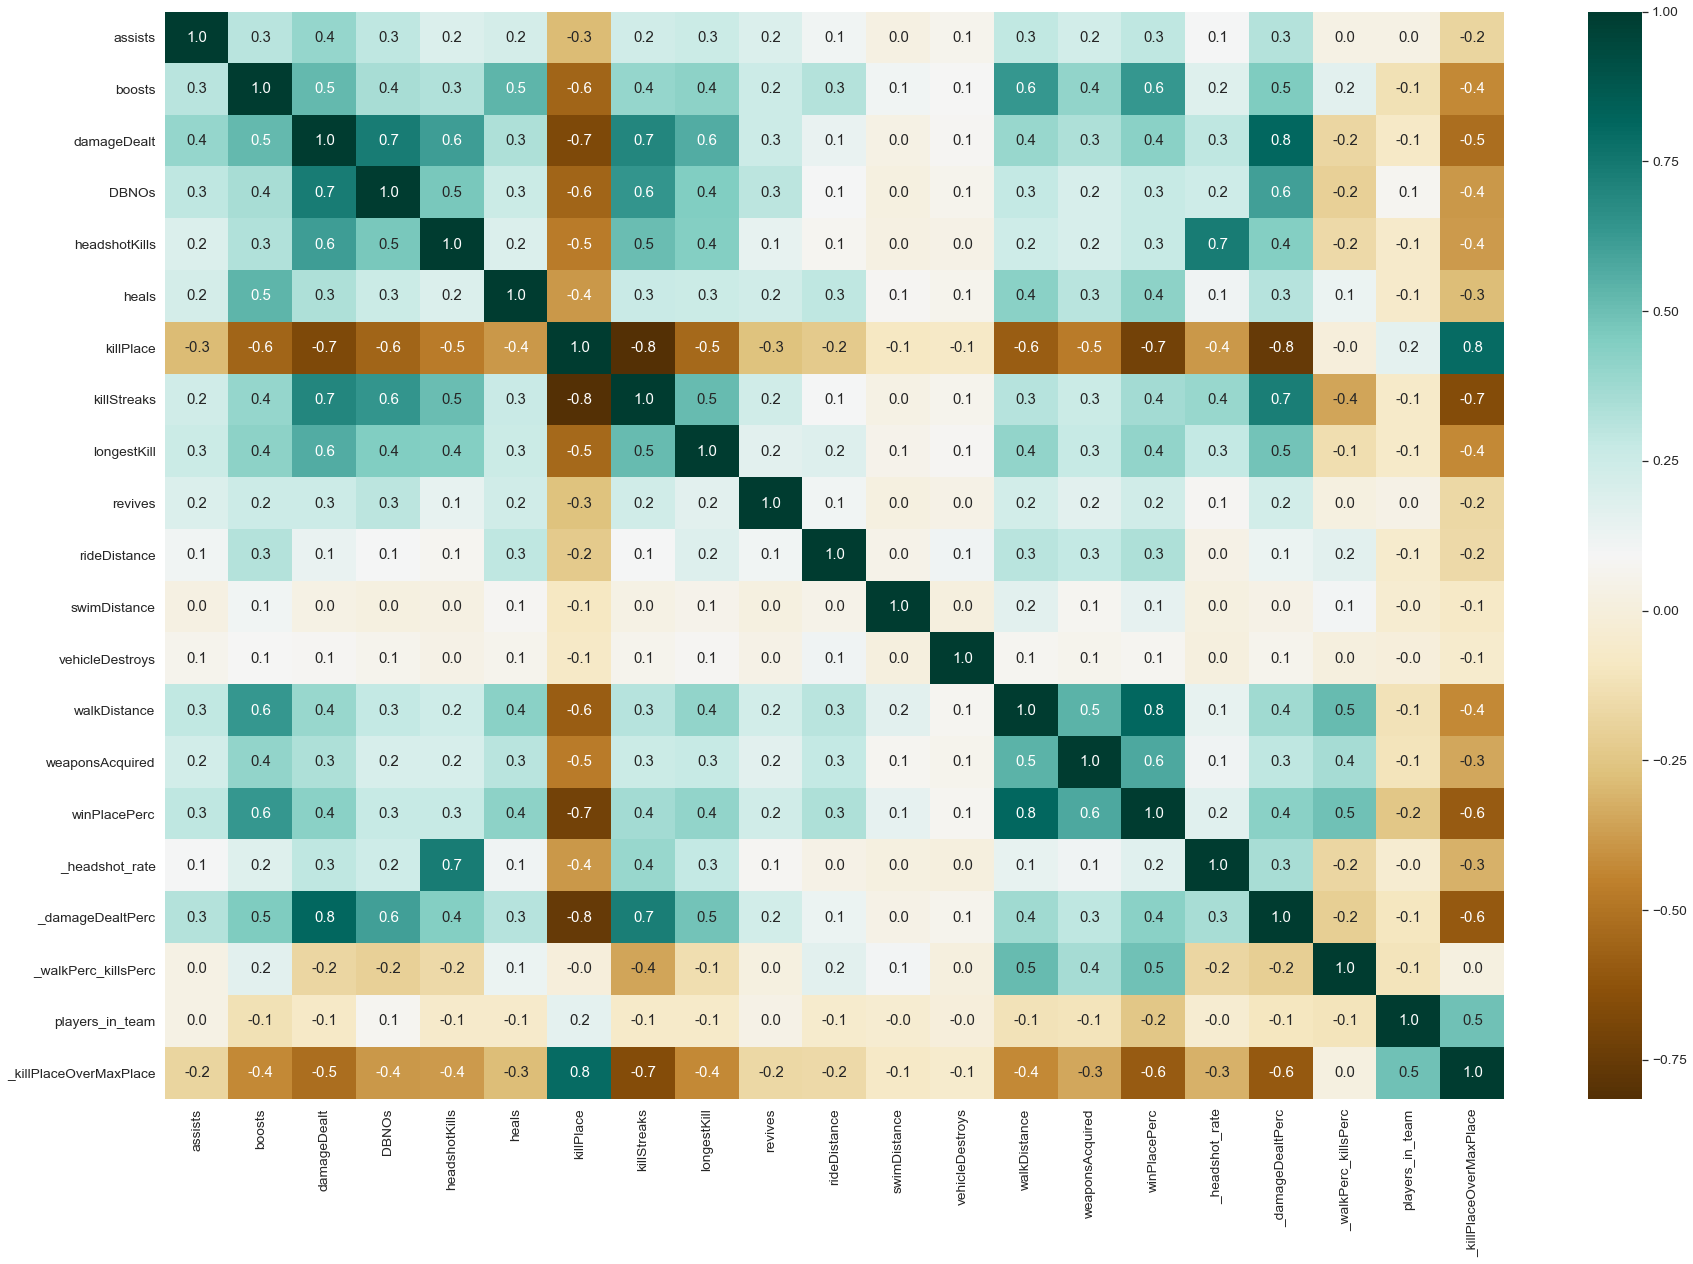

In [91]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [92]:
#saving highly correlated data
cleaned_data.to_csv('Highly_correlated_data.csv', index=False)

#### Modifying the test data

In [93]:
highly_corr = pd.read_csv('Highly_correlated_data.csv')
highly_corr = reduce_mem_usage(highly_corr)

highly_corr.shape

Memory usage of dataframe is 829.57 MB --> 344.27 MB (Decreased by 58.5%)


(4349359, 25)

In [94]:
X_train = highly_corr[highly_corr['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = highly_corr[highly_corr['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)


Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId','Id'], axis=1, inplace=True)
X_test.drop(['matchId','groupId','Id'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(4349359, 21) (0, 21)


#### Dealing with categorical feature

In [95]:
print('There are {} different Match types in the dataset.'.format(highly_corr['matchType'].nunique()))

There are 3 different Match types in the dataset.


In [96]:
# One hot encode matchType
highly_corr = pd.get_dummies(highly_corr, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = highly_corr.filter(regex='matchType')
matchType_encoding.head()

,matchType_duo,matchType_solo,matchType_squad
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational huge. We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

In [97]:
# Turn groupId and match Id into categorical types
highly_corr['groupId'] = highly_corr['groupId'].astype('category')
highly_corr['matchId'] = highly_corr['matchId'].astype('category')

# Get category coding for groupId and matchID
highly_corr['groupId_cat'] = highly_corr['groupId'].cat.codes
highly_corr['matchId_cat'] = highly_corr['matchId'].cat.codes

# Get rid of old columns
highly_corr.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
highly_corr[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,609242,29996
1,821700,32654
2,837266,3131
3,1330566,45133
4,1744863,20468


In [98]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
highly_corr.drop(columns = ['Id'], inplace=True)

#### Sampling

In [99]:
# Take sample for debugging and exploration
sample = 500000
df_sample = highly_corr.sample(sample)

In [100]:
# Split sample into training data and target variable
X = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=1)

In [102]:
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_test.shape)

Sample train shape:  (440000, 25) Sample target shape:  (440000,) Sample validation shape:  (60000, 25)


#### Defining function for calculating Mean Absolute Error (MAE)

In [105]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Function to print the MAE (Mean Absolute Error) score

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_test), y_test)]
    #Score of the training dataset obtained using an out-of-bag estimate.
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

#### Basic Random Forest

In [106]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03730754707087962, 'mae val: ', 0.05890816563739574]


#### Finding Feature Importance using Random Forest

In [107]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [109]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, X); fi[:15]

,cols,imp
13,walkDistance,0.278329
6,killPlace,0.234147
17,_walkPerc_killsPerc,0.119103
1,boosts,0.082163
19,_killPlaceOverMaxPlace,0.070544
14,weaponsAcquired,0.052527
5,heals,0.040780
10,rideDistance,0.024390
16,_damageDealtPerc,0.015329
8,longestKill,0.015084


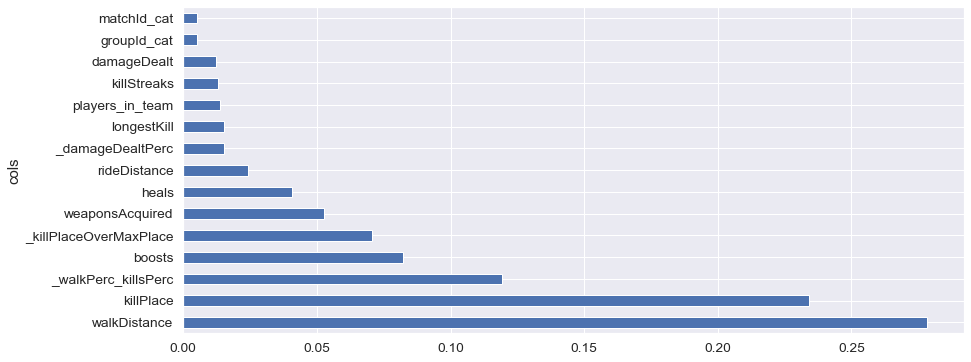

In [110]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:15].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [111]:
X_train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killStreaks', 'longestKill', 'revives', 'rideDistance',
       'swimDistance', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       '_headshot_rate', '_damageDealtPerc', '_walkPerc_killsPerc',
       'players_in_team', '_killPlaceOverMaxPlace', 'matchType_duo',
       'matchType_solo', 'matchType_squad', 'groupId_cat', 'matchId_cat'],
      dtype='object')

In [112]:
print(X_train.shape, y_train.shape)

(440000, 25) (440000,)


In [114]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

# Make a DataFrame with only significant features
df_keep = X[to_keep].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=1)

Significant features:  15


#### Building a Random Forest Model with top features

In [115]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.036976830968736676, 'mae val: ', 0.058536532364698766]


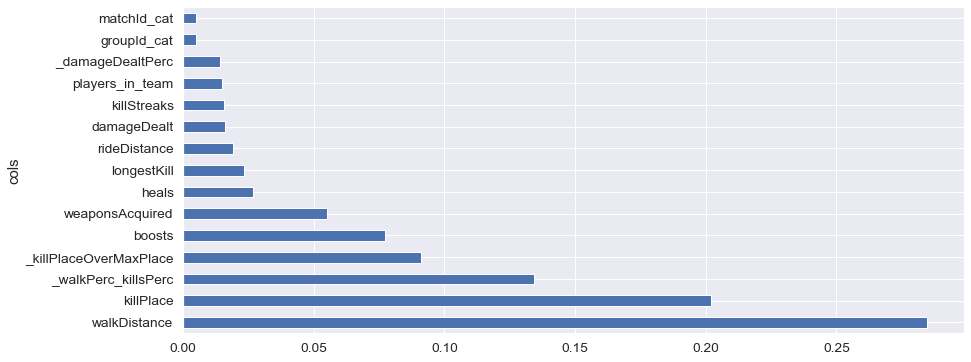

In [145]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, X)

for i in list(fi_to_keep['cols']):
    if i not in list(to_keep):
        fi_to_keep = fi_to_keep[fi_to_keep.cols != i]
        
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

[]

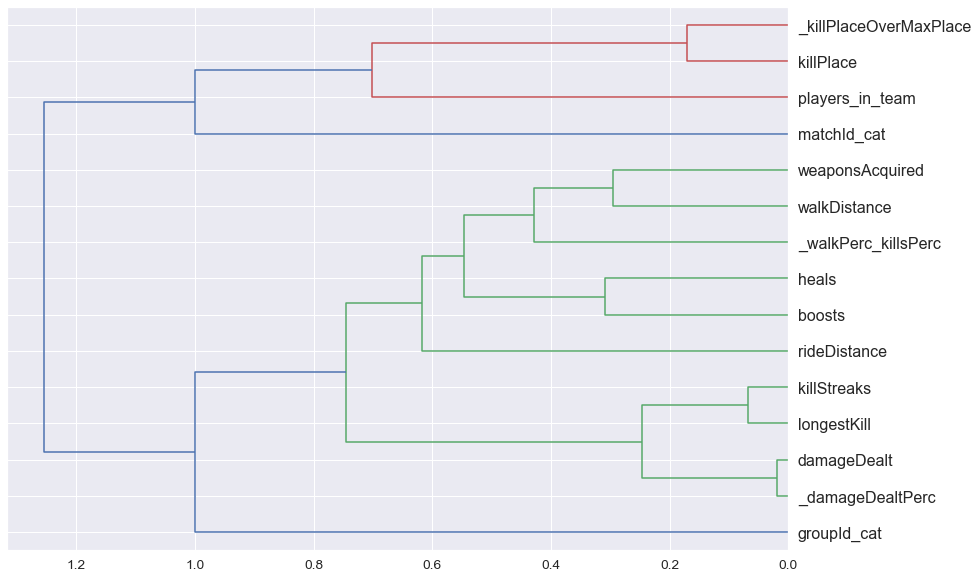

In [146]:
import scipy
from scipy.cluster import hierarchy as hc
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [147]:
train = highly_corr.copy()

In [148]:
X = train.drop(columns = ['winPlacePerc']) # all columns except target
X = X[to_keep] # Keep only relevant features
y = train['winPlacePerc'] # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [149]:
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_test.shape)

Sample train shape:  (3479487, 15) Sample target shape:  (3479487,) Sample validation shape:  (869872, 15)


In [150]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.031671383190505914, 'mae val: ', 0.05709265280448658]


#### Modifying the test data

In [151]:
test = pd.read_csv('test_V2.csv')
test = reduce_mem_usage(test)

Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


In [152]:
#Adding same features to test data
agg = test.groupby(['groupId']).size().to_frame('players_in_team')
test = test.merge(agg, how='left', on=['groupId'])
test['_headshot_rate'] = test['headshotKills'] / test['kills']
test['_headshot_rate'] = test['_headshot_rate'].fillna(0)
test['_totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['_playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['_killsNorm'] = test['kills']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtNorm'] = test['damageDealt']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtPerc'] = test['damageDealt'].rank(pct=True).values
test['_healthItems'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['_totalDistance'] == 0))
test['_killPlacePerc'] = test['killPlace'].rank(pct=True).values
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkPerc_killsPerc'] = test['_walkDistancePerc'] / test['_killsPerc']
test['_killPlaceOverMaxPlace'] = test['killPlace'] / test['maxPlace']
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkDistancePerSec'] = test['walkDistance'] / test['matchDuration']

In [153]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,players_in_team,_headshot_rate,_totalDistance,_playersJoined,_killsNorm,_damageDealtNorm,_damageDealtPerc,_healthItems,killsWithoutMoving,_killPlacePerc,_killsPerc,_walkDistancePerc,_walkPerc_killsPerc,_killPlaceOverMaxPlace,_walkDistancePerSec
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0,4,0.000000,588.000000,92,0.00,55.576799,0.405548,0,False,0.766654,0.284210,0.475680,1.673695,2.607143,0.312102
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0,2,0.000000,6686.000000,96,2.08,186.264006,0.740433,6,False,0.111587,0.831127,0.758297,0.912373,0.229167,1.113749
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0,4,0.000000,787.799988,94,0.00,24.804000,0.318389,4,False,0.513972,0.284210,0.525046,1.847389,1.750000,0.439375
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0,2,0.000000,1812.000000,89,0.00,72.727196,0.446258,0,False,0.566769,0.284210,0.722077,2.540649,1.200000,0.988004
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0,3,0.666667,2963.000000,95,3.15,346.710013,0.899034,5,False,0.069081,0.910626,0.906597,0.995576,0.250000,2.234540


In [154]:
# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

In [155]:
test.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'players_in_team', '_headshot_rate',
       '_totalDistance', '_playersJoined', '_killsNorm', '_damageDealtNorm',
       '_damageDealtPerc', '_healthItems', 'killsWithoutMoving',
       '_killPlacePerc', '_killsPerc', '_walkDistancePerc',
       '_walkPerc_killsPerc', '_killPlaceOverMaxPlace', '_walkDistancePerSec',
       'groupId_cat', 'matchId_cat'],
      dtype='object')

In [156]:
to_keep

13              walkDistance
6                  killPlace
17       _walkPerc_killsPerc
1                     boosts
19    _killPlaceOverMaxPlace
14           weaponsAcquired
5                      heals
10              rideDistance
16          _damageDealtPerc
8                longestKill
18           players_in_team
7                killStreaks
2                damageDealt
23               groupId_cat
24               matchId_cat
Name: cols, dtype: object

In [157]:
# # Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,walkDistance,killPlace,_walkPerc_killsPerc,boosts,_killPlaceOverMaxPlace,weaponsAcquired,heals,rideDistance,_damageDealtPerc,longestKill,players_in_team,killStreaks,damageDealt,groupId_cat,matchId_cat
0,588.000000,73,1.673695,0,2.607143,1,0,0.0,0.405548,0.000000,4,0,51.459999,357523,5514
1,2017.000000,11,0.912373,4,0.229167,6,2,4669.0,0.740433,361.899994,2,1,179.100006,231759,5268
2,787.799988,49,1.847389,0,1.750000,4,4,0.0,0.318389,0.000000,4,0,23.400000,39107,10783
3,1812.000000,54,2.540649,0,1.200000,3,0,0.0,0.446258,0.000000,2,0,65.519997,634157,2174
4,2963.000000,7,0.995576,4,0.250000,4,1,0.0,0.899034,60.060001,3,1,330.200012,352749,5106


### Part 4: Final Predition

In [158]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})
pred_df
# Create submission file
# pred_df.to_csv("submission.csv", index=False)

,Id,winPlacePerc
0,9329eb41e215eb,0.263765
1,639bd0dcd7bda8,0.915463
2,63d5c8ef8dfe91,0.733653
3,cf5b81422591d1,0.608322
4,ee6a295187ba21,0.914424
...,...,...
1934169,a316c3a13887d5,0.717502
1934170,5312146b27d875,0.449098
1934171,fc8818b5b32ad3,0.884445
1934172,a0f91e35f8458f,0.789113
